### Well, let's work on some real data now!

In [1]:
import uproot
import numpy as np

import dask
import dask.array as da
import dask_awkward as dak

import matplotlib.pyplot as plt
import time

[DoubleMuParked dataset](https://opendata.cern.ch/record/12341#) from 2012 in NanoAOD format reduced on muons.

61,540,413 events

In [2]:
real_data = "./data/Run2012BC_DoubleMuParked_Muons.root" + ":Events"

### Setting up the extremely small cluster, so we can see some diagnostics
This is completely optional! I'm doing it for the dask diagnostic tools, but you might skip it if you just want to run stuff on your local computer! But it's important to note that these Dask workflows are scalable from single-machines to entire clusters.

In [3]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(processes=False,threads_per_worker=8)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.1.7:8787/status,
Dashboard: http://192.168.1.7:8787/status,Workers: 1
Total threads: 8,Total memory: 7.61 GiB
Status: running,Using processes: False
Comm: inproc://192.168.1.7/18963/1,Workers: 1
Dashboard: http://192.168.1.7:8787/status,Total threads: 8
Started: Just now,Total memory: 7.61 GiB
Comm: inproc://192.168.1.7/18963/4,Total threads: 8
Dashboard: http://192.168.1.7:33589/status,Memory: 7.61 GiB
Nanny: None,


### Making the actual dask task-graph

In [4]:
test_path = uproot.dask(real_data)
pt = test_path['Muon_pt']
phi = test_path['Muon_phi']
eta = test_path['Muon_eta']
muons = dak.zip({"pt":pt,"eta":eta,"phi":phi})
selected_muons = muons[dak.num(muons)>=2]
pt1 = selected_muons[:,0].pt
pt2 = selected_muons[:,1].pt
eta1 = selected_muons[:,0].eta
eta2 = selected_muons[:,1].eta
phi1 = selected_muons[:,0].phi
phi2 = selected_muons[:,1].phi

mass = np.sqrt(pt1*pt2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2))*2)
h,bins = da.histogram(mass,bins=200,range=(0,200))

### Visualizing the dask graph

In [5]:
h.visualize('graphs/real-data-graph-optimized.png',optimize_graph=True)
h.visualize('graphs/real-data-graph.png')

### The actual computation

In [6]:
start = time.time()

# No data has been read until this point
hist_arr = h.compute()

end = time.time()
print(end-start)

91.31982111930847


### And the Z-peak!

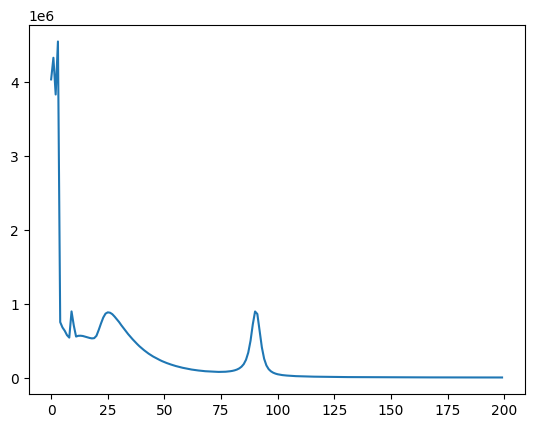

In [7]:
plt.plot(hist_arr)